<a href="https://colab.research.google.com/github/Pepe-Padilla/deep-learning/blob/main/lateFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Late Fusion - DeepLearning


### Indice
1. Introducción
2. Importación y Normalización de datos
3. Entrenamiento
4. Gráfica de Perdidas
5. Test
6. Concluciones

##  1. Introducción

**Práctica DL** - Ejercicio de Bootcamp Inteligencia Artificial Full Stack Edición III

Este proyecto es un entregable para la práctica del Master Bootcamp Inteligencia Artificial Full Stack Edición III realizado por el centro de formación [@Keepcoding](https://github.com/KeepCoding)

---

El objetivo de este trabajo consiste en resolver un problema del mundo real empleando para ello técnicas vistas durante las sesiones de dicho módulo. En concreto, se trabajará en predecir la condición médica sufrida por una cohorte de pacientes a partir de las diferentes fuentes de información disponibles (imágenes y datos tabulares).

Las imagenes deben entrenar y obtener una de los siguientes respuestas:

| Enfermedad | Descripción | Código | Indice en salida |
|------------|-------------|--------|------------------|
| Actinic keratoses y carcinoma de células escamosas | Tipo de cáncer de piel | akiec | 0 |
| Nevus melanocítico | Lesión benigna común | nv | 1 |
| Melanoma | Tipo de cáncer de piel agresivo | mel | 2 |
| Lesiones benignas de queratosis | Incluyen lentigo solar y queratosis seborreica | bkl | 3 |
| Dermatofibroma | Lesión benigna del tejido fibroso | df | 4 |
| Vasculares | Lesiones vasculares como hemangiomas | vasc | 5 |
| Lesión de células basales | Un tipo de cáncer de piel menos agresivo que el melanoma | bcc | 6 |

---

Para el Late Fusion se usará la combinación aprendida de las predicciones realizadas por el modelo 1D y 2D desarrollado previamente.

## 2. Importación y Normalización de datos

### 2.1 Imports

In [1]:
# 1. Primero las importaciones que necesitaremos
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

### 2.2 Obtención de datos

In [3]:
# 2. Obtención de datos
#dataframe = pd.read_csv("/content/HAM10000_metadata.csv", usecols=[1], engine='python', skipfooter=3)
#df = dataframe.values
df_label = pd.read_csv("/content/HAM10000_metadata.csv", sep=",")
df_image = pd.read_csv("/content/hnmist_28_28_RGB.csv", sep=",")
tabular_model = tf.keras.models.load_model("/content/1d_model.keras")
image_model = tf.keras.models.load_model("/content/2d_model.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### 2.3 Inspección de elementos

In [4]:
# 2. Inspección de los datos
print(df_image.head())
print(df_image.info())
print(df_label.head())
print(df_label.info())

# Tratamiento df_label
# Solo age tiene null, solo se me ocurre rellenar con la mediana
df_label["age"] = df_label["age"].fillna(df_label["age"].median())
df_label['age'] = df_label['age'] / 100  # Escalamos considerando 100 como el máximo teórico

# para evitar problemas después, convertir el tipo de age a un float compatible para Tensor
df_label['age'] = df_label['age'].astype('float32')

# Convertimos las variables 'sex' y 'localization' a categorías one-hot encoding
df_label = pd.get_dummies(df_label, columns=['sex', 'localization','dx'])

# 4. Separamos datos
dropX = ['lesion_id','image_id','dx_akiec','dx_bcc','dx_bkl','dx_df','dx_mel','dx_nv','dx_vasc','dx_type']
dropY = ['lesion_id','image_id','dx_type','age','sex_female','sex_male','sex_unknown','localization_abdomen','localization_acral','localization_back','localization_chest','localization_ear',
  'localization_face','localization_foot','localization_genital','localization_hand','localization_lower extremity',
  'localization_neck','localization_scalp','localization_trunk','localization_unknown','localization_upper extremity']
x_label = df_label.drop(dropX, axis=1).astype(np.float32).values  # Convertimos todo a float32
y = df_label.drop(dropY, axis=1).astype(np.float32).values  # Convertimos todo a float32

# 3. Preprocesamiento
# Separación de características e imágenes
X = df_image.values  # Extraemos los valores de píxeles
X = X.reshape(-1, 28, 28, 3)  # Reestructuramos a formato de imagen (28x28x3)
x_image = X.astype(np.float32) / 255.0  # Normalización de valores RGB




   pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2342  pixel2343  \
0        197        154        185        202  ...        134        173   
1        123         93        126        158  ...         82         60   
2        201        142        160        206  ...        149        167   
3        143        103        119        171  ...         73         44   
4        215        162        191        225  ...        201        209   

   pixel2344  pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  \
0        124        138        183        147

### 2.4 Separación de datos

In [5]:
# 4. Separación de datos
X_label_train, X_label_test, X_image_train, X_image_test, y_train, y_test = train_test_split(
    x_label, x_image, y, shuffle=True, test_size=0.2, random_state=42
)

X_label_train, X_label_val, X_image_train, X_image_val, y_train, y_val = train_test_split(
    X_label_train, X_image_train, y_train, shuffle=True, test_size=0.15, random_state=42
)

### 2.5 Verificación

In [6]:
# 5. Verificación de normalización
y_traindf = pd.DataFrame(y_train)

print(y_traindf.describe())
print(X_label_train.shape)
print(X_image_train.shape)

                 0            1            2            3            4  \
count  6810.000000  6810.000000  6810.000000  6810.000000  6810.000000   
mean      0.033333     0.052129     0.107342     0.011160     0.109692   
std       0.179524     0.222301     0.309581     0.105058     0.312524   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                 5            6  
count  6810.000000  6810.000000  
mean      0.670485     0.015859  
std       0.470059     0.124940  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       1.000000     0.000000  
75%       1.000000     0.000000  
max       1.000000     1.000000  
(6810, 19)
(6810, 28, 28, 3

## 3. Entrenamiento

In [14]:
# Definición de la estructura del modelo de Late Fusion
def build_late_fusion_model(tabular_model, vision_model, tabular_input_shape, vision_input_shape):
    # Entradas
    tabular_input = Input(shape=tabular_input_shape, name="tabular_input")
    vision_input = Input(shape=vision_input_shape, name="vision_input")

    # Predicciones de cada modelo individual
    tabular_pred = tabular_model(tabular_input)
    vision_pred = vision_model(vision_input)

    # Fusión de las salidas
    merged = Concatenate()([tabular_pred, vision_pred])

    # Clasificador final
    output = Dense(7, activation="softmax", name="final_output")(merged)

    # Definición del modelo Late Fusion
    late_fusion_model = Model(inputs=[tabular_input, vision_input], outputs=output)
    return late_fusion_model

# Asumimos que los modelos tabular_model y vision_model ya están entrenados
# y que conocemos los tamaños de sus entradas
tabular_input_shape = (19,)  # Ajustar según las características tabulares
vision_input_shape = (28, 28, 3)  # Ajustar según el modelo de visión

# Crear el modelo de Late Fusion
model = build_late_fusion_model(tabular_model, image_model, tabular_input_shape, vision_input_shape)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(3e-3),  # en el primer intento con 1e-4 la gráfica salió muy planta comienzo a subirlo
                                     # 1e-3 mejoró pero sigue plana
                                     # 5e-3 me he pasado, el codo esta muy fuerte y se nota un ligero overfitting
              metrics=['accuracy'])

n_epochs = 50

# 8. Entrenamiento del modelo
H = model.fit([X_label_train, X_image_train], y_train,
          batch_size=100,
          epochs=n_epochs,
          validation_data=([X_label_val, X_image_val], y_val))

# 9. Evaluación del modelo
scores = model.evaluate([X_label_test, X_image_test], y_test)
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])




Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.1363 - loss: 2.0463 - val_accuracy: 0.5849 - val_loss: 1.5416
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6206 - loss: 1.4325 - val_accuracy: 0.6481 - val_loss: 1.2078
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6587 - loss: 1.1814 - val_accuracy: 0.6656 - val_loss: 1.1027
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6688 - loss: 1.0942 - val_accuracy: 0.6664 - val_loss: 1.0513
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6669 - loss: 1.0551 - val_accuracy: 0.6664 - val_loss: 1.0067
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6760 - loss: 1.0092 - val_accuracy: 0.6664 - val_loss: 0.9640
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6689 - loss: 0.9688 - val_accuracy: 0.6980 - val_loss: 0.9193
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6901 - loss: 0.9490 - val_accuracy: 0.7080 - 

## 4. Gráfica de Perdidas

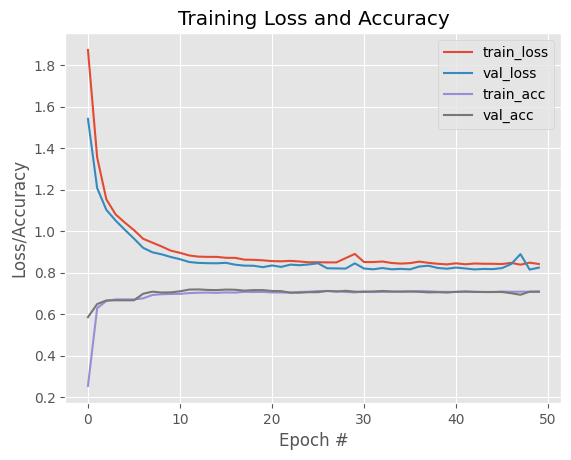

In [15]:
# veamos nuestra función de pérdidas con respecto a las épocas ejecutadas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [16]:
# Guardamos el resultado
model.save("/content/latefusion_model.keras")

## 5. Concluciones

In [17]:
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tabular_input             │ (None, 19)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vision_input (InputLayer) │ (None, 28, 28, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 7)              │            140 │ tabular_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 7)              │        439,559 │ vision_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 14)             │              0 │ sequential[4][0],      │
│ (Concatenate)             │                        │                │ sequential_5[4][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ final_output (Dense)      │ (None, 7)              │            105 │ concatenate_4[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,317,878 (5.03 MB)

 Trainable params: 439,036 (1.67 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 878,074 (3.35 MB)

conclusiones